---
title: "Tagliare una linea con un punto"
description: "Tagliare una linea con un punto non è un'attività banalissima da fare in Python, in questo nuovo post mostrerò tre possibili strade per farlo."
lang: it
date: "2022 04 18"
open-graph:
    title: "Tagliare una linea con un punto"
    description: "Tagliare una linea con un punto non è un'attività banalissima da fare in Python, in questo nuovo post mostrerò tre possibili strade per farlo."
    image: ../../project_logo.jpg
categories: [point]
image: ../../project_logo.jpg
format:
    html:
        toc: true
        code-fold: false
execute:
  enabled: false
---

Questa volta l'argomento trattato non nasce da una attività simile fatta con QGIS come per gli altri [post](https://maxdragonheart.github.io/PyGIS-Blog/) precedenti ma dalla soluzione ad un problema in cui mi sono imbattuto e che mi ha portato via un po' di tempo con non pochi grattacapi!

La richiesta era semplice, all'apparenza, ma non avevo fatto i conti con i *[Floating Point](https://docs.python.org/3/tutorial/floatingpoint.html) problems*. In pratica, avendo una linea ed un punto lontano da essa dovevo trovare la distanza minima tra punto e lina e spezzare la linea sul punto di contatto tra la congiungente tra punto e linea.

## Prima di iniziare


### Librerie
Per raggiungere l'obiettivo userò le librerie che seguono:

In [1]:
from matplotlib import pyplot as plt
from shapely import wkt
from shapely.ops import substring, nearest_points, snap, split
from shapely.geometry import Point, LineString

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Fonti dati

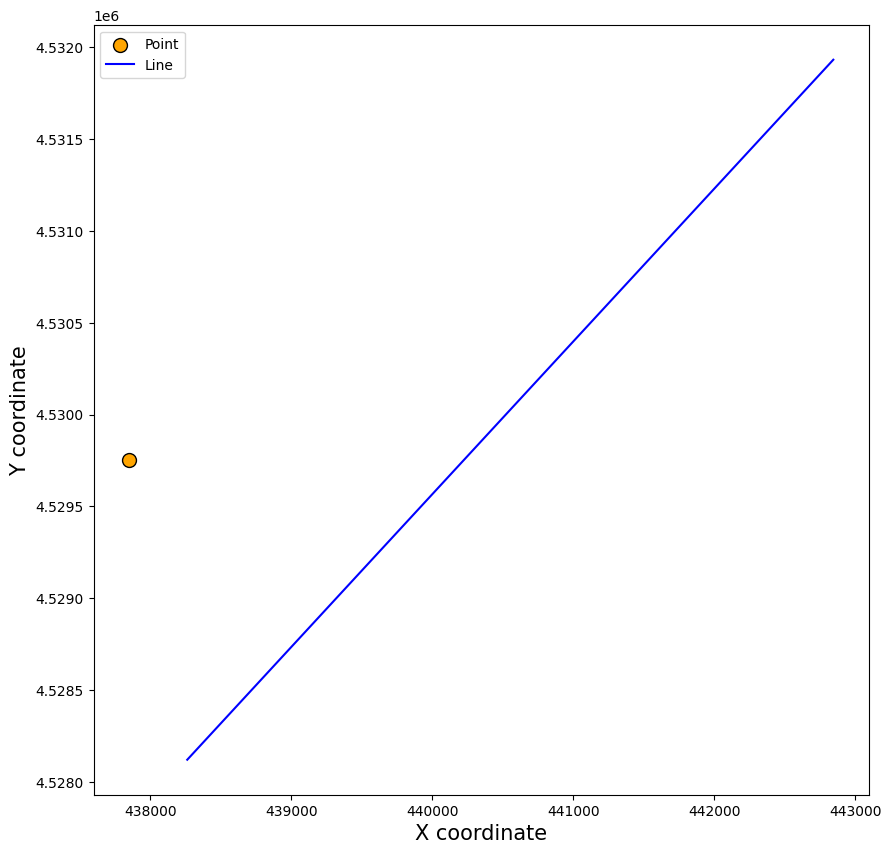

In [2]:
point = wkt.loads('POINT (437845.7257845374 4529752.584581757)')
line = wkt.loads('LINESTRING (438260.8093535866 4528121.6968436185, 442844.8639858717 4531930.850183684)')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)

ax.scatter(
    *point.xy,
    label='Point',
    s=100,
    facecolor='orange',
    edgecolor='black'
)
plt.plot(*line.xy, label='Line', color='blue')

plt.legend()

plt.show()

# Premessa

Ho capito delle difficoltà legate ai *floating point* dopo questa esperienza:

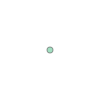

In [3]:
minimum_distance = nearest_points(point, line)[1]

minimum_distance

Con `nearest_points()` ottengo il punto sulla linea più prossimo al mio punto di riferimento, a questo punto è naturale tagliare la linea con questo punto:

In [4]:
splitted_line = split(line, minimum_distance)
wkt.dumps(splitted_line)

'GEOMETRYCOLLECTION (LINESTRING (438260.8093535865773447 4528121.6968436185270548, 442844.8639858717215247 4531930.8501836843788624))'

La funzione `split()` restiuisce una *geometry collection* composta da due *LineString*. Almeno questo è quello che mi sarei aspettato leggendo anche la documentazione della libreria usata, ma purtroppo anzicchè ottenere due linee ne ho ottenuta una, la linea in ingresso.
Quindi mi è sorto un dubbio: **ma il punto con cui ho provato a tagliare la linea è realmente sulla linea?**

In [5]:
snap_point = snap(minimum_distance, line, 1e-8)

assert minimum_distance.wkt == snap_point.wkt
assert line.distance(minimum_distance) < 1e-8

Gli `assert` non hanno dato esito negativo, quindi il punto è sulla linea. **E allora perchè non riesco a tagliarla??**

Facendo un po' di ricerche ho capito che il problema è legato ai *floating point* e così mi sono dato da fare per trovare una soluzione senza però trascurare altre possibili strade nel dubbio che magari potesse esserci un'altra strada o più di una. Infatti chiedendo un po' in giro ho trovato altre due soluzioni oltre la mia.

# 1. Soluzione mia
Uso `nearest_points()` per trovare il punto più prossimo alla linea, quindi prendo il *from_node* ed il *to_node* della mia linea e li uso per creare due linee:

In [6]:
first_linestring = LineString([Point(line.coords[0]), minimum_distance])
last_linestring = LineString([minimum_distance, Point(line.coords[1])])
minimum_distance_line = LineString([point, minimum_distance])

In questo modo ho tagliato la linea ed ho creato la linea congiungente il mio punto iniziale con la linea stessa.

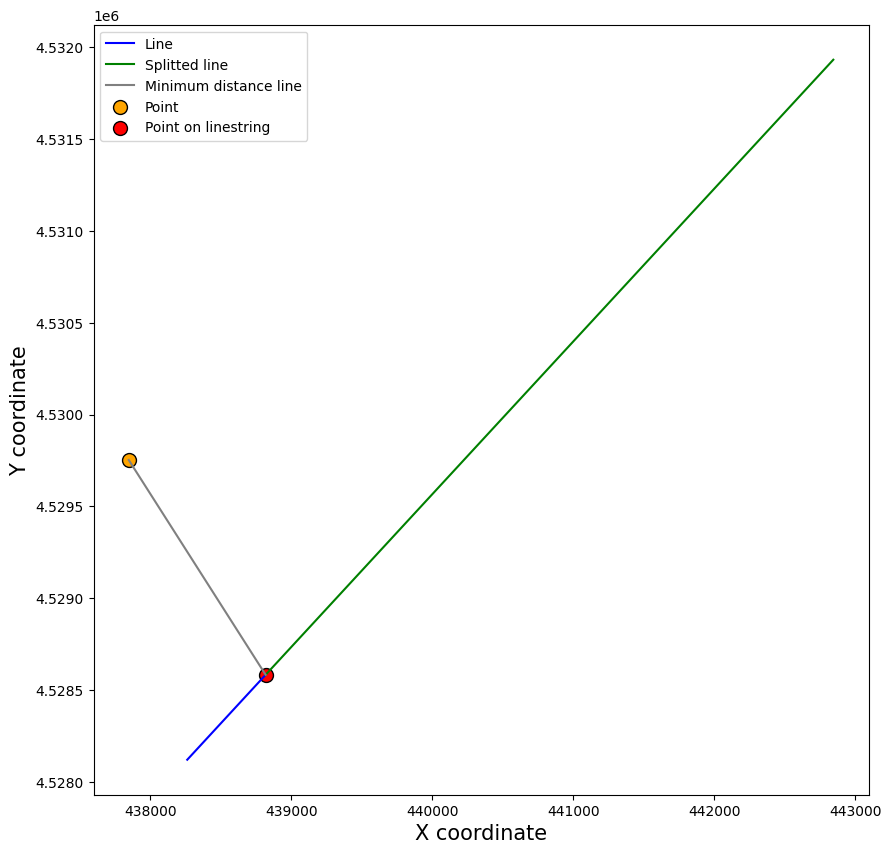

In [7]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.set_xlabel('X coordinate', fontsize=15)
ax1.set_ylabel('Y coordinate', fontsize=15)

plt.plot(*first_linestring.xy, label='Line', color='blue')
plt.plot(*last_linestring.xy, label='Splitted line', color='green')
plt.plot(*minimum_distance_line.xy, label='Minimum distance line', color='grey')
ax1.scatter(
    *point.xy,
    label='Point',
    s=100,
    facecolor='orange',
    edgecolor='black'
)
ax1.scatter(
    *minimum_distance.xy,
    label='Point on linestring',
    s=100,
    facecolor='red',
    edgecolor='black'
)

plt.legend()

plt.show()

# 2. Soluzione basata su `projection()`
Soluzione suggerita da due utenti sui social. In pratica si proietta il punto sulla linea andando ad individuare il punto di proiezione sulla stessa con cui si costruiscono le linee risultanti dal taglio.

In [8]:
distance = line.project(point, normalized=True)
distance

0.12131606906976151

In [9]:
line_length = line.length

first_linestring2 = substring(
    geom=line,
    start_dist=line_length*0,
    end_dist=line_length*distance
)

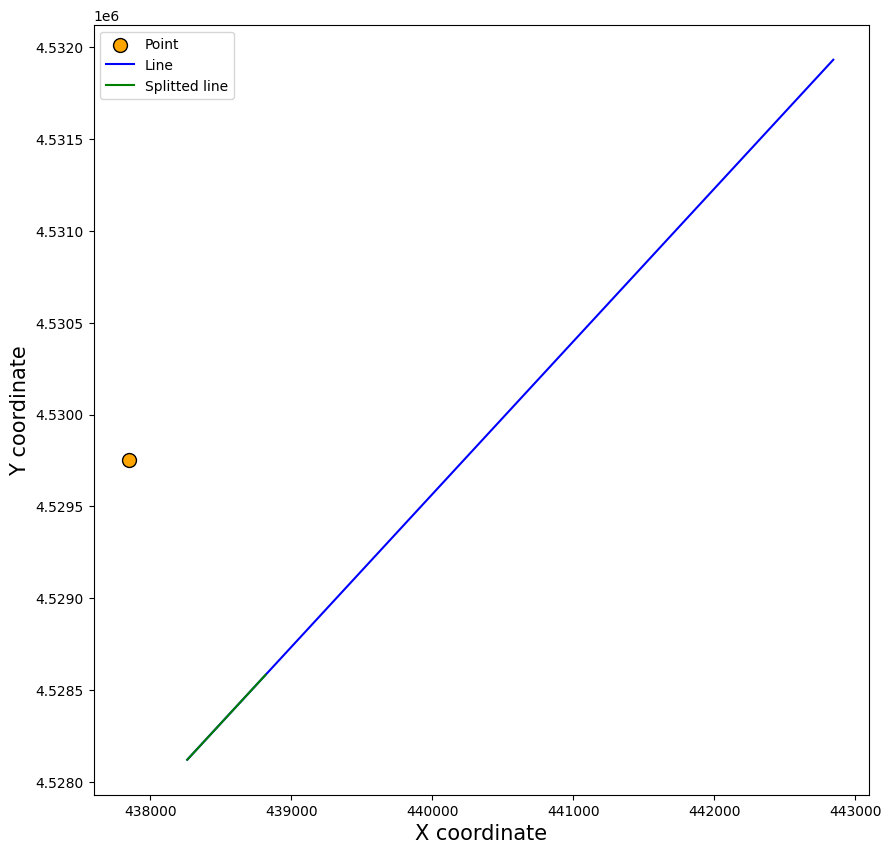

In [10]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
ax2.set_xlabel('X coordinate', fontsize=15)
ax2.set_ylabel('Y coordinate', fontsize=15)

ax2.scatter(
    *point.xy,
    label='Point',
    s=100,
    facecolor='orange',
    edgecolor='black'
)
plt.plot(*line.xy, label='Line', color='blue')
plt.plot(*first_linestring.xy, label='Splitted line', color='green')

plt.legend()

plt.show()

L'altra linea ed il punto di taglio si estraggono facilmente con procedimenti simili a quelli precedenti.

# 3. Soluzione basata su `snap()`
Soluzione suggerita da [M.Laloux](https://github.com/mlaloux) [qui](https://gis.stackexchange.com/a/428987/72195). In realtà ce ne è anche un'altra basata su `buffer()` ma avevo già incontrato precedetemente problemi legati ai *floating point* con quella funzione per cui l'ho scartata. La funzione usata per questa soluzione aggancia il punto di taglio alla linea e quindi effettua il taglio.

In [11]:
splitted_lines = split(snap(line, minimum_distance, 0.0001), minimum_distance)

wkt.dumps(splitted_lines)

'GEOMETRYCOLLECTION (LINESTRING (438260.8093535865773447 4528121.6968436185270548, 438816.9288419764488935 4528583.8083533188328147), LINESTRING (438816.9288419764488935 4528583.8083533188328147, 442844.8639858717215247 4531930.8501836843788624))'

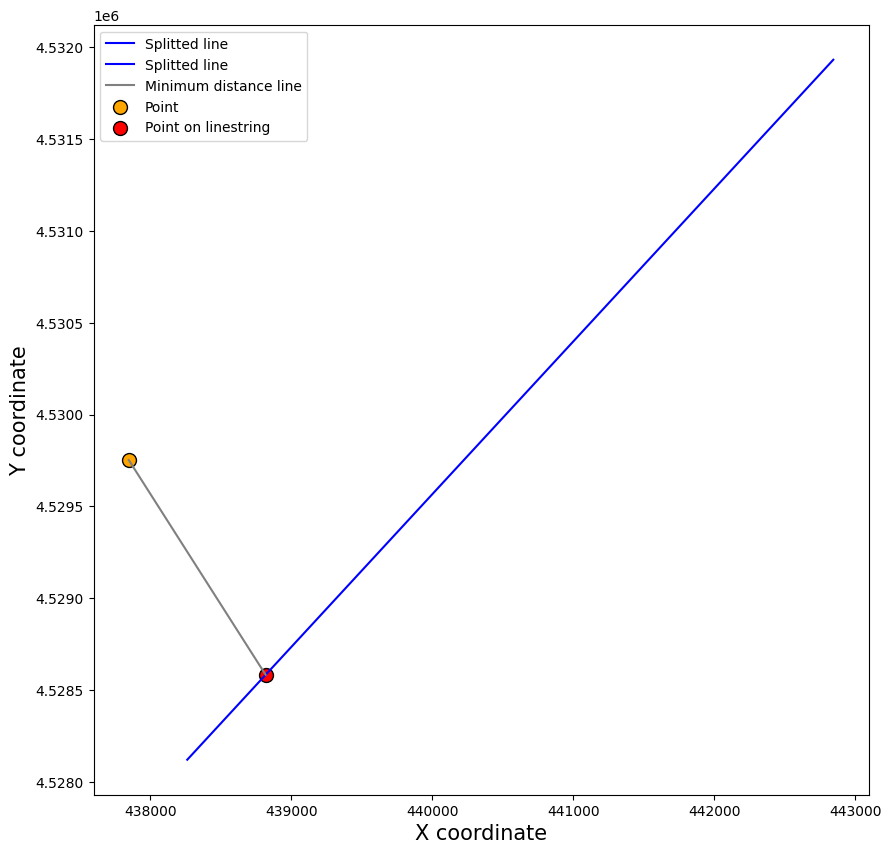

In [12]:
fig3, ax3 = plt.subplots(figsize=(10, 10))
ax3.set_xlabel('X coordinate', fontsize=15)
ax3.set_ylabel('Y coordinate', fontsize=15)

new_lines = [minimum_distance_line]
for line in splitted_lines.geoms:
    plt.plot(*line.xy, label='Splitted line', color='blue')
    new_lines.append(line)
plt.plot(*minimum_distance_line.xy, label='Minimum distance line', color='grey')
ax3.scatter(
    *point.xy,
    label='Point',
    s=100,
    facecolor='orange',
    edgecolor='black'
)
ax3.scatter(
    *minimum_distance.xy,
    label='Point on linestring',
    s=100,
    facecolor='red',
    edgecolor='black'
)

plt.legend()

plt.show()

# Conclusione

Purtroppo i problemi legati ai floating points in [shapely](https://github.com/shapely/shapely/issues?q=is%3Aissue+is%3Aopen+floating+point) restano irrisolti da un po' di anni. Le soluzioni proproste si pongoo nel caso più semplice: una linea composta da soli due vertex e cioè il *from_node* ed il *to_node*. Per situazioni più complesse si potrebbe iterare il discorso andando a segmentare la linea per poi ricongiungere i segmenti che fanno parte delle linee risultati dal taglio.

**PS**: i riquadri di warning che si vedono ogni tanto *fanno parte del gioco*, sono avvertimenti per prossime modifiche da fare al codice per poter essere utilizzabile con la prossima versione della libreria di turno.